In [1]:
from load_dataset import load_dataset
from main import train
from model import NERF

from PIL import Image
import numpy as np
import tqdm

import torch
from torch import optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import time

from load_dataset import load_dataset
from render import render_rays

In [2]:
image_size = 50
(origins, dirs), colors = load_dataset("data/nerf_synthetic/lego/", image_size)

origins_test = origins[-image_size*image_size*3:].cuda()
dirs_test = dirs[-image_size*image_size*3:].cuda()
colors_test = colors[-image_size*image_size*3:].cuda()

origins = origins[:-image_size*image_size*3]
dirs = dirs[:-image_size*image_size*3]
colors = colors[:-image_size*image_size*3]

In [3]:
model = NERF().cuda()

In [4]:
origins = origins.cuda()
dirs = dirs.cuda()
colors = colors.cuda()

In [5]:
def run_epoch(rays, colors, model, optimizer=None, bs=2000):
    origins, dirs = rays
    dataset = TensorDataset(origins, dirs, colors)
    loader = DataLoader(dataset, batch_size=bs, shuffle=(optimizer!=None))

    output_C = []
    losses = []

    for b_origins, b_dirs, b_colors in loader:
        if optimizer is not None:
            optimizer.zero_grad()

        C_f, C_c = render_rays((b_origins, b_dirs), model, model, device="cuda")
        loss = F.mse_loss(b_colors, C_f) + F.mse_loss(b_colors, C_c)
        loss.backward()
        losses.append(loss.detach().cpu().numpy())

        if optimizer is not None:
            optimizer.step()
    
        output_C.append(C_f)

    return torch.cat(output_C, dim=0), np.mean(losses)

In [6]:
rays = (origins, dirs)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
for i in range(1000):
    C, loss = run_epoch(rays, colors, model, optimizer)
    print(loss, i)
    if i%10==0:
        torch.save(model,"model")
            

got img


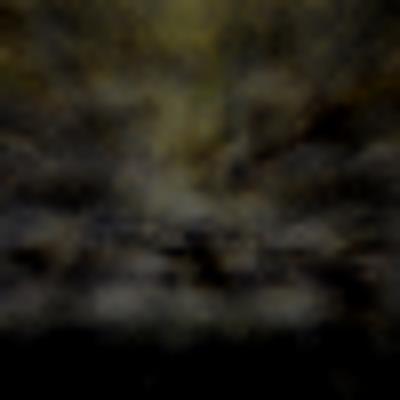

In [12]:
si = 0* image_size * image_size
ei =  1* image_size * image_size
C, loss = run_epoch(
    (origins[si:ei], dirs[si:ei]),
    colors[si:ei],
    model,
)
print("got img")
out_img = C.detach().cpu().numpy().reshape((image_size, image_size, 3))
Image.fromarray(np.uint8(np.clip((out_img) * 255, 0, 255))).resize((400,400))

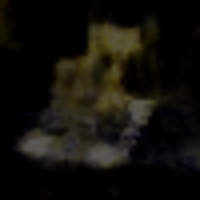